In [6]:
import os
import random
import requests
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from io import BytesIO
from tqdm import tqdm

import torch
from torchvision import models, transforms

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

## Load housing price dataset

In [3]:
price_df = pd.read_csv("data/housing_price_california.csv", index_col=0)
price_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [8]:
len(price_df)

20640

## Pull SVIs from Goolge Map API

In [13]:
def is_streetview_available(lat, lon):
    """Check if a Street View image is available at the given latitude and longitude."""
    params = {
        "location": f"{lat},{lon}",
        "key": API_KEY
    }
    response = requests.get(META_URL, params=params)
    data = response.json()
    return data.get("status") == "OK" and data.get("pano_id") is not None

def download_streetview_image(lat, lon, heading=0, pitch=0, fov=90, size="640x640", save=True):
    """Download and optionally save a Street View image from the specified location."""
    params = {
        "location": f"{lat},{lon}",
        "size": size,
        "heading": heading,
        "pitch": pitch,
        "fov": fov,
        "key": API_KEY
    }
    response = requests.get(BASE_URL, params=params)

    if response.status_code == 200:
        image = Image.open(BytesIO(response.content))
        if save:
            os.makedirs(SAVE_DIR, exist_ok=True)
            filename = f"lat{lat:.6f}_lon{lon:.6f}_hdg{heading}.jpg"
            filepath = os.path.join(SAVE_DIR, filename)
            image.save(filepath)
            return filepath
        return image
    else:
        print(f"Failed to download image at ({lat}, {lon})")
        return None

In [6]:
import getpass
import os

if not os.getenv("GOOGLEMAP_API_KEY"):
    os.environ["GOOGLEMAP_API_KEY"] = getpass.getpass("Enter your Google Map API key: ")

Enter your Google Map API key:  ········


In [10]:
# Google Maps API settings
API_KEY = os.environ["GOOGLEMAP_API_KEY"] 
BASE_URL = "https://maps.googleapis.com/maps/api/streetview"
META_URL = "https://maps.googleapis.com/maps/api/streetview/metadata"
SAVE_DIR = "images"

In [14]:
# Sample a subset of data points
sampled = price_df.sample(n=200, random_state=42).copy()
sampled["image_path"] = None

# Filter locations with available Street View images
print("Checking Street View availability and downloading images...")
valid_rows = []
for idx, row in tqdm(sampled.iterrows(), total=len(sampled)):
    lat, lon = row["Latitude"], row["Longitude"]
    if is_streetview_available(lat, lon):
        path = download_streetview_image(lat, lon, heading=0)
        if path:
            row["image_path"] = path
            valid_rows.append(row)

filtered_df = pd.DataFrame(valid_rows)

Checking Street View availability and downloading images...


100%|███████████████████████████████████████████████████████████| 200/200 [04:20<00:00,  1.30s/it]


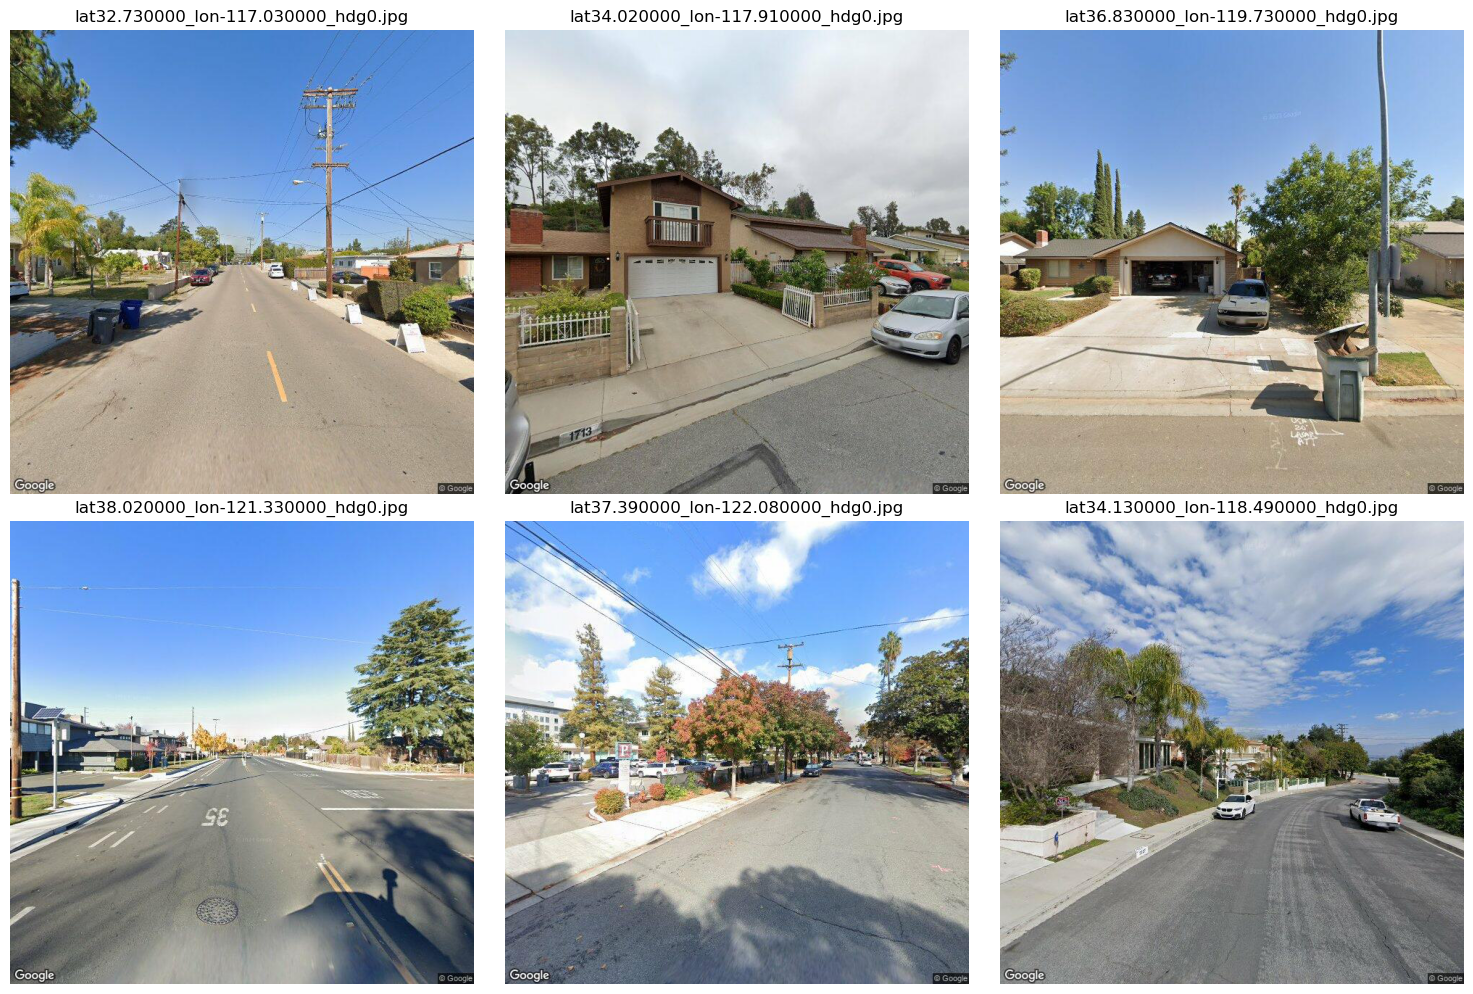

In [10]:
import math

# Display random pulled SVIs
folder_path = 'images'

valid_exts = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
all_files = [f for f in os.listdir(folder_path) if os.path.splitext(f)[1].lower() in valid_exts]

num_samples = 6
selected_files = random.sample(all_files, min(num_samples, len(all_files)))

max_per_row = 3 
total_imgs = len(selected_files)
rows = math.ceil(total_imgs / max_per_row)

plt.figure(figsize=(max_per_row * 5, rows * 5)) 

for i, filename in enumerate(selected_files):
    img_path = os.path.join(folder_path, filename)
    img = Image.open(img_path)
    plt.subplot(rows, max_per_row, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(filename)

plt.tight_layout()
plt.show()

## Generate image feature vector

In [15]:
# Define ResNet feature extractor
resnet = models.resnet18(pretrained=True)
resnet.fc = torch.nn.Identity()  # Remove the final classification layer
resnet.eval()

# Define image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def extract_image_features(image_path):
    """Extract 512-dimensional image features using pretrained ResNet."""
    img = Image.open(image_path).convert("RGB")
    x = transform(img).unsqueeze(0)
    with torch.no_grad():
        feat = resnet(x)
    return feat.squeeze().numpy()

/opt/anaconda3/envs/huggingface/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/huggingface/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/kanxuanhe/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|████████████████████████████████████████████████████████| 44.7M/44.7M [00:03<00:00, 15.0MB/s]


In [16]:
# Extract image features
print("Extracting image features...")
image_features = []
for path in tqdm(filtered_df["image_path"]):
    if path and os.path.exists(path):
        feat = extract_image_features(path)
    else:
        feat = np.zeros(512)
    image_features.append(feat)

image_feat_df = pd.DataFrame(image_features, columns=[f"img_feat_{i}" for i in range(512)])
image_feat_df

Extracting image features...


100%|███████████████████████████████████████████████████████████| 153/153 [00:02<00:00, 57.32it/s]


,img_feat_0,img_feat_1,img_feat_2,img_feat_3,img_feat_4,img_feat_5,img_feat_6,img_feat_7,img_feat_8,img_feat_9,...,img_feat_502,img_feat_503,img_feat_504,img_feat_505,img_feat_506,img_feat_507,img_feat_508,img_feat_509,img_feat_510,img_feat_511
0,1.447826,1.591330,1.086519,0.567170,0.346720,0.774041,0.279734,0.873795,0.380994,0.081234,...,1.132018,0.593427,0.047922,1.043673,0.991651,0.131474,0.989959,1.076053,1.322407,0.000000
1,1.379483,0.452584,1.240305,1.154204,0.243022,0.635839,0.005607,1.370461,0.074061,0.280762,...,0.261767,0.543304,0.364958,0.242182,0.719999,1.150580,0.338032,3.087002,0.835450,0.061755
2,1.591632,1.383198,1.036944,1.999877,1.326964,0.235495,0.627830,2.391460,0.427079,1.309410,...,0.499071,0.688933,1.522172,0.956014,0.016484,2.833626,0.086156,4.720090,0.931587,0.003616
3,0.643437,0.236788,2.613985,0.340861,0.202928,0.405271,0.183736,3.139334,1.559501,0.496151,...,0.125600,1.925640,0.185988,1.879764,0.162765,0.883911,0.140506,6.219033,2.157843,0.336261
4,1.326731,0.788375,0.431579,1.169211,1.341801,0.848573,0.307950,0.641042,0.840244,0.007856,...,0.657345,1.012116,0.303452,0.940860,0.758969,0.991987,0.378378,2.837158,1.168219,0.194860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,1.117554,1.997688,2.125102,1.235650,0.569549,0.618666,0.592752,0.102017,0.647781,0.990664,...,0.844478,2.792157,0.241992,1.496633,0.750434,0.884591,0.132963,2.430108,0.225717,0.024510
149,1.692892,1.719554,1.110917,0.498370,0.804719,0.374954,0.339197,1.166629,0.198648,0.495144,...,0.640675,0.682569,0.525934,0.526908,0.302790,0.928106,0.699401,1.793137,1.284804,0.058184
150,1.820687,0.847918,1.332574,0.542417,0.836816,0.201826,0.393273,1.739722,0.541651,1.575090,...,0.186323,1.916648,0.650330,1.411245,1.122710,0.670063,0.906083,3.248194,0.334911,0.307790
151,0.980663,0.727357,1.607711,0.218971,1.031796,2.794864,0.305223,2.971267,0.590576,0.114522,...,0.324178,1.766148,0.507365,1.729058,0.937316,0.013232,0.290266,3.989219,0.590894,0.060703


## Train a prediction model based on image features
3 modes with different input features
1. only tabular features (HouseAge, Pupulation, etc.)
2. only image features
3. combined

In [36]:
import matplotlib.pyplot as plt
def plot_prediction(y_test, y_pred, title=None, save_dir=None):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='gray')
    plt.xlabel("True Price (Target)")
    plt.ylabel("Predicted Price")
    plt.title(f"Prediction vs Ground Truth ({title} mode)")
    plt.grid(True)
    plt.tight_layout()
    
    # Save and show the plot
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plot_filename = os.path.join(save_dir, f"scatter_{title}.png")
        plt.savefig(plot_filename)
        plt.show()
        print(f"Saved plot: {plot_filename}")

In [33]:
# only tabular features
feature_mode = "tabular"
tabular_features = filtered_df.drop(columns=["Target", "image_path"])
X = tabular_features
y = filtered_df["Target"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
print(f"Training model with feature mode: {feature_mode}")
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
print(f"[{feature_mode}] Mean Absolute Error (MAE): {mae:.2f}")

Training model with feature mode: tabular
[tabular] Mean Absolute Error (MAE): 0.55


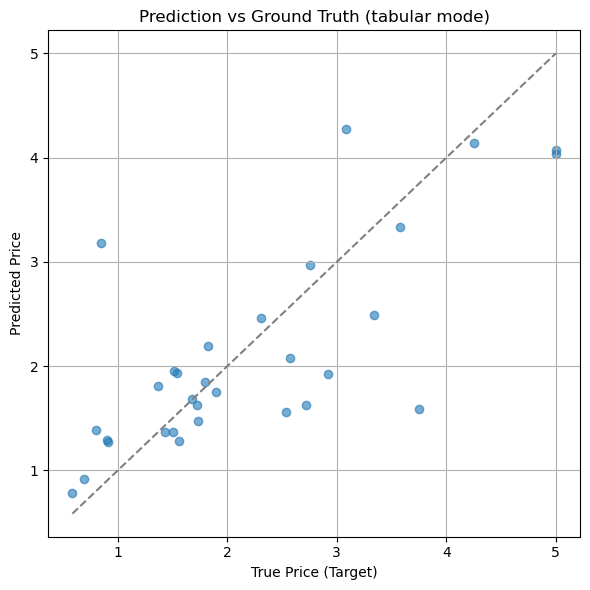

Saved plot: output/scatter_tabular.png


In [38]:
save_dir = "output"
plot_prediction(y_test, y_pred, title="tabular", save_dir=save_dir)

In [44]:
# only image features
feature_mode = "image"
X = image_feat_df
y = filtered_df["Target"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
print(f"Training model with feature mode: {feature_mode}")
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
print(f"[{feature_mode}] Mean Absolute Error (MAE): {mae:.2f}")

Training model with feature mode: image
[image] Mean Absolute Error (MAE): 1.05


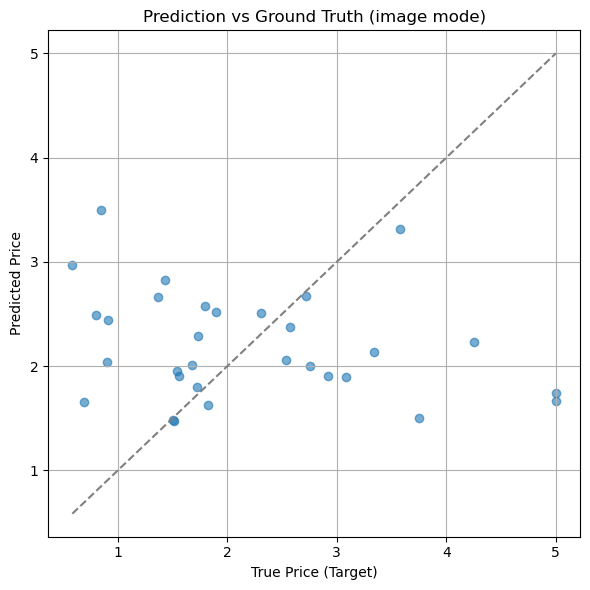

Saved plot: output/scatter_image.png


In [45]:
plot_prediction(y_test, y_pred, title="image", save_dir=save_dir)

In [46]:
# combined features
feature_mode = "combined"
tabular = filtered_df.drop(columns=["Target", "image_path"]).reset_index(drop=True)
X = pd.concat([tabular, image_feat_df], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
print(f"Training model with feature mode: {feature_mode}")
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
print(f"[{feature_mode}] Mean Absolute Error (MAE): {mae:.2f}")

Training model with feature mode: combined
[combined] Mean Absolute Error (MAE): 0.60


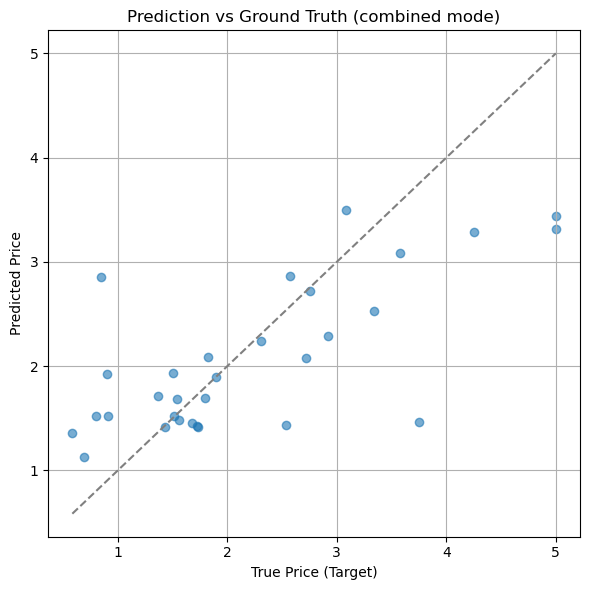

Saved plot: output/scatter_combined.png


In [47]:
plot_prediction(y_test, y_pred, title="combined", save_dir=save_dir)

### Extension: Why is Image-Only Model Less Accurate?

- Street View images may **not directly show buildings**—trees, roads, fences dominate many views.
- **Environmental features** (e.g., greenery, cleanliness, road width) may not correlate strongly with price.
- Image content might be **inconsistent or noisy** (e.g., cars blocking view, outdated imagery).
- Limited **sample size (~100)** makes image-only models prone to overfitting.

### Ideas for Improvement

- Use **multi-angle views** (e.g., 0°, 90°, 180°, 270°) for more complete context.
- Apply **semantic segmentation** to estimate:
  - Building ratio
  - Tree/green space coverage
  - Road vs. sidewalk ratio
- Test if these visual ratios **correlate with housing price** as additional features.
- Consider using **domain-specific pretraining or fine-tuning** on urban/street imagery.
- Expand dataset or augment image data to improve generalization.